<a href="https://colab.research.google.com/github/tomonari-masada/course2022-sml/blob/main/09_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 糖尿病をロジスティック回帰で予測してみる

* 有名なPima Indians Diabetes Databaseを使う（下リンク先）

 * https://www.kaggle.com/uciml/pima-indians-diabetes-database

* ロジスティック回帰、そして、分類の評価については、下記も参照
 * https://developers.google.com/machine-learning/crash-course/logistic-regression/
 * https://developers.google.com/machine-learning/crash-course/classification/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.model_selection import StratifiedKFold

%config InlineBackend.figure_format = 'retina'

## 1) データの読み込み

In [2]:
diabetes = pd.read_csv('/content/drive/MyDrive/data/diabetes.csv')

In [3]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
y = diabetes['Outcome']
X = diabetes.drop('Outcome', axis=1)

## 2) 訓練データ、テストデータに分割

**この分割は変えないようにしてください。**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

In [6]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000
mean,3.796012,120.973926,69.171779,20.835890,79.903374,32.117638,0.460816,33.291411
std,3.325152,31.248977,19.109787,16.099415,112.705173,7.687094,0.321493,11.801392
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,100.000000,64.000000,0.000000,0.000000,27.300000,0.238000,24.000000
50%,3.000000,117.000000,72.000000,23.000000,37.500000,32.300000,0.364500,29.000000
75%,6.000000,141.000000,80.000000,33.000000,127.250000,36.600000,0.605000,41.000000
max,17.000000,199.000000,122.000000,99.000000,744.000000,59.400000,2.420000,81.000000


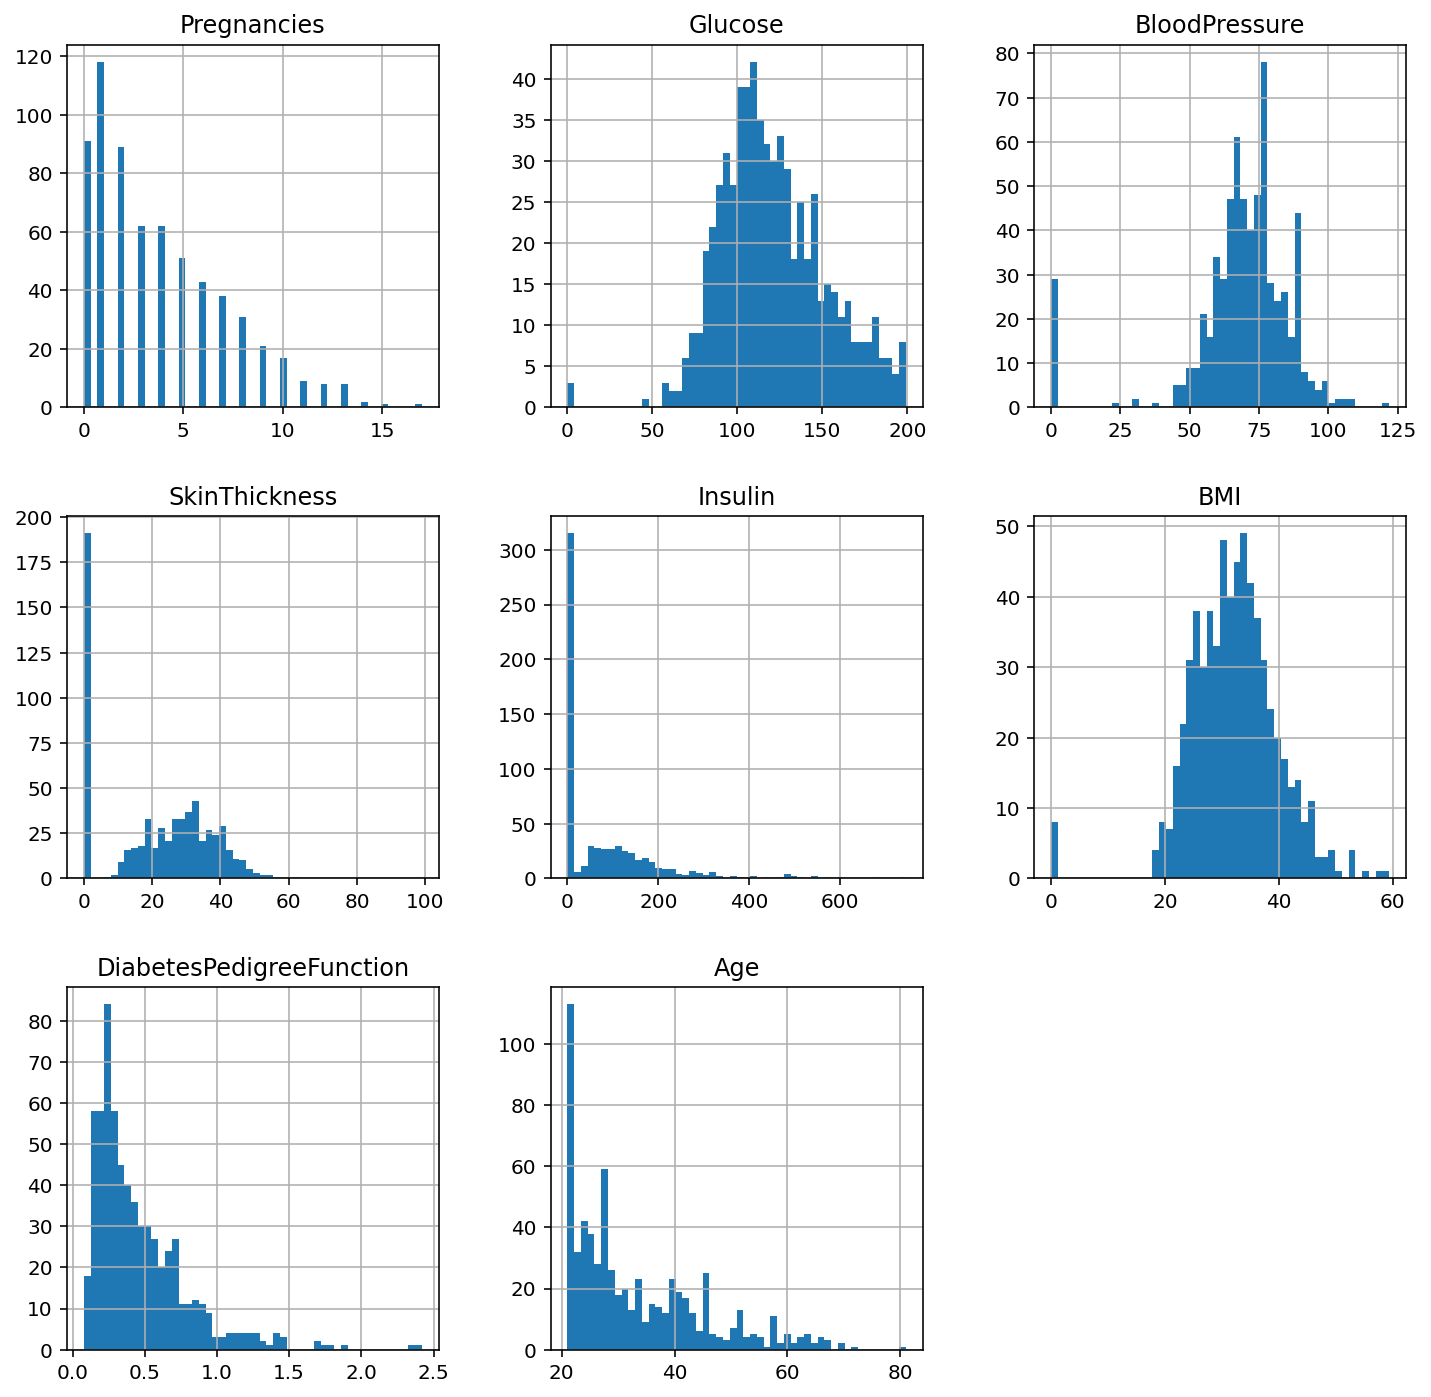

In [7]:
X_train.hist(bins=50, figsize=(12,12));

* 以下、訓練データ部分を使って、交差検証によって良いモデルを探す。

---



## 3) デフォルト設定のロジスティック回帰をベースラインとみなしてテストデータでの評価値を得る
* 交差検証も何もせずに、単にテストセット以外の部分で、モデルの学習を実行する。

In [8]:
baseline = LogisticRegression(random_state=123)
baseline.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=123)

* `max_iter`が小さいとの警告が出ているので、増やして学習しなおし。

In [9]:
baseline = LogisticRegression(max_iter=1000, random_state=123)
baseline.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=123)

* 大丈夫だったので、テストデータでの最終評価値を得る。

In [10]:
print(f'test score: {baseline.score(X_test, y_test):.4f}')

test score: 0.8103


* Area under ROC curveも計算してみる。


In [11]:
y_test_pred_proba = baseline.predict_proba(X_test)
print(f'ROC AUC: {roc_auc_score(y_test, y_test_pred_proba[:,1]):.4f}')

ROC AUC: 0.8617


* ROC curveを描いてみる。
 * https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [12]:
def draw_roc_curve(model, X_test, y_test):
  y_score = model.decision_function(X_test)

  fpr, tpr, _ = roc_curve(y_test, y_score)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.4f})')
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")

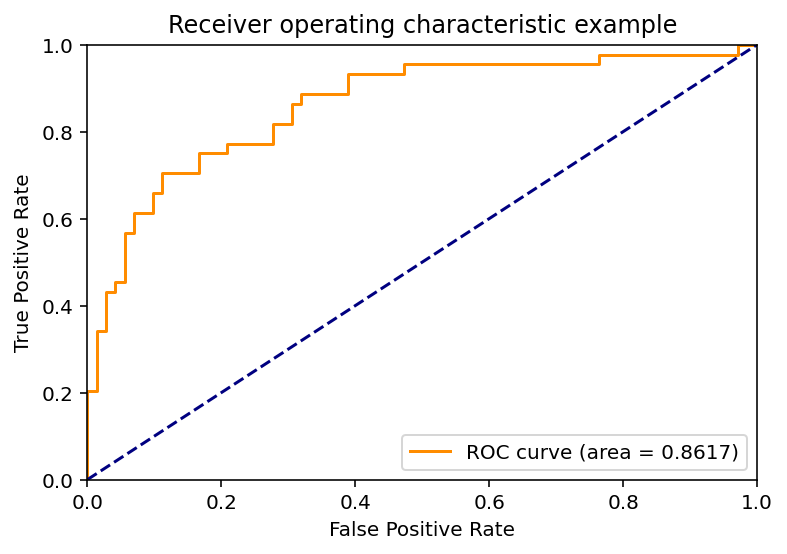

In [13]:
draw_roc_curve(baseline, X_test, y_test);

* これをベースラインとみなす。
* これより良い結果を得るべく、試行錯誤する。
* 試行錯誤した結果として辿り着いたモデルで、最後に一回、テストデータ上での評価を行う。

* ロジスティック回帰についてscoreがどのように計算されているかの確認
 * thresholdが0.5である必要は、実は、ない。
 * thresholdを、交差検証で決定してもよい。

* `threshold = 0.5`とすれば、次のセルで求まる値と、上で求めたtest scoreは、一致する。

In [14]:
threshold = 0.5
n_correct_answers = ((baseline.predict_proba(X_test)[:,1] >= threshold) * 1 == y_test).sum()
print(f'test score at a threshold {threshold}: {n_correct_answers / len(y_test):.4f}')

test score at a threshold 0.5: 0.8103


## 4) 交差検証しつつ試行錯誤する

* 元々の訓練データのコピーを作っておく。

In [15]:
X_train_original = X_train.copy()
X_test_original = X_test.copy()

### A) 交差検証の準備

In [16]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

### B) 交差検証による評価のための関数を定義しておく

In [17]:
def cv(skf, X_train, y_train, preprocess=None, **kwargs):

  # キーワード引数として、モデルの設定を指定できるようにしてある。
  for kwarg in kwargs:
    print(f'{kwarg} = {kwargs[kwarg]}')

  # 交差検証のループ
  scores = list()
  for train_index, valid_index in skf.split(X_train, y_train):

    cv_X_train = X_train.iloc[train_index]
    cv_y_train = y_train.iloc[train_index]
    cv_X_valid = X_train.iloc[valid_index]
    cv_y_valid = y_train.iloc[valid_index]

    # データの前処理
    #   その都度、関数preprocessを定義してから、この関数cvを呼び出す。
    if preprocess:
      cv_X_train, cv_X_valid = preprocess(cv_X_train, cv_X_valid)

    # ロジスティック回帰の学習
    if not 'max_iter' in kwargs:
      model = LogisticRegression(**kwargs, max_iter=1000)
    else:
      model = LogisticRegression(**kwargs)
    model.fit(cv_X_train, cv_y_train)

    # 検証データでの評価
    score = model.score(cv_X_valid, cv_y_valid)
    print(f'score: {score:.4f}')
    scores.append(score)

  mean_score = np.array(scores).mean()
  print(f'mean score: {mean_score:.4f}')
  return mean_score

### C) デフォルト設定のロジスティック回帰の性能を評価する
* 交差検証で性能評価するとどうなるかを確認している。

In [18]:
cv(skf, X_train, y_train);

score: 0.8182
score: 0.7879
score: 0.7385
score: 0.7692
score: 0.7692
score: 0.7538
score: 0.7538
score: 0.7846
score: 0.7231
score: 0.7385
mean score: 0.7637


### D) BloodPressureへの対応

* まず、属性「BloodPressure」について、ヒストグラムを描いてよくよく眺める。


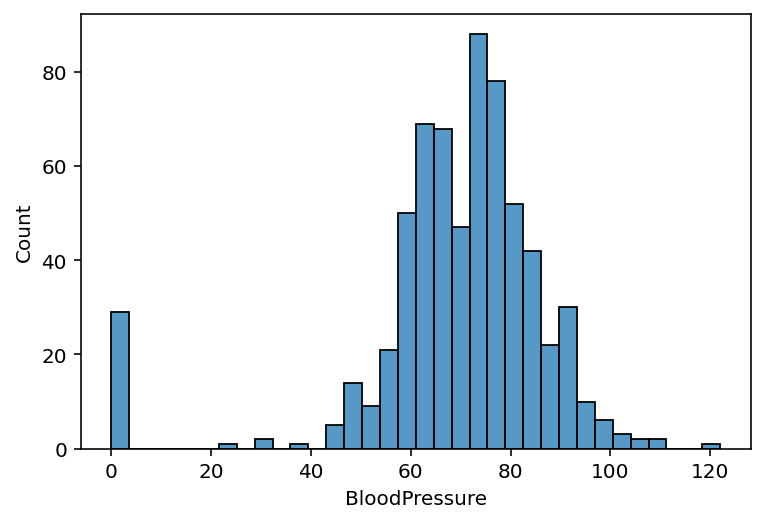

In [19]:
sns.histplot(X_train['BloodPressure']);

* 0という値がけっこうあるらしい。実は、これは欠測値。そこで、中央値で埋めることにする。

imputation fill value for BloodPressure: 72.0


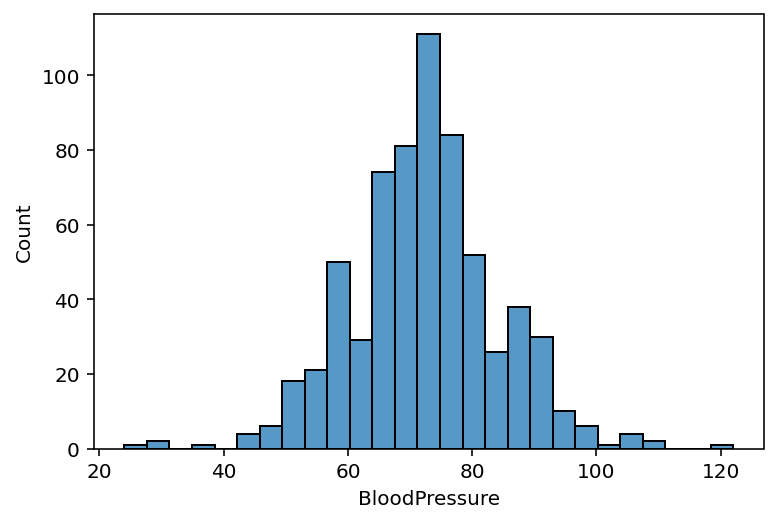

In [20]:
X_train_copy = X_train.copy()

feature = 'BloodPressure'
imp = SimpleImputer(missing_values=0, strategy='median')
X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

sns.histplot(X_train_copy[feature]);

* 交差検証で評価する。

In [21]:
def preprocess(X_train, X_valid):
  imp = SimpleImputer(missing_values=0, strategy='median')

  X_train_copy = X_train.copy()
  X_valid_copy = X_valid.copy()

  feature = 'BloodPressure'
  X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
  X_valid_copy[feature] = imp.transform(X_valid[[feature]])
  print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

  return X_train_copy, X_valid_copy

In [22]:
cv(skf, X_train, y_train, preprocess=preprocess);

imputation fill value for BloodPressure: 72.0
score: 0.8182
imputation fill value for BloodPressure: 72.0
score: 0.8182
imputation fill value for BloodPressure: 72.0
score: 0.7538
imputation fill value for BloodPressure: 72.0
score: 0.7538
imputation fill value for BloodPressure: 72.0
score: 0.7692
imputation fill value for BloodPressure: 72.0
score: 0.7846
imputation fill value for BloodPressure: 72.0
score: 0.7538
imputation fill value for BloodPressure: 72.0
score: 0.7846
imputation fill value for BloodPressure: 72.0
score: 0.7077
imputation fill value for BloodPressure: 72.0
score: 0.7385
mean score: 0.7683


* 下のようにテストセット以外全体で欠損値を埋めても、結果は変わらない。

In [23]:
X_train_copy = X_train.copy()

feature = 'BloodPressure'
imp = SimpleImputer(missing_values=0, strategy='median')
X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

cv(skf, X_train_copy, y_train);

imputation fill value for BloodPressure: 72.0
score: 0.8182
score: 0.8182
score: 0.7538
score: 0.7538
score: 0.7692
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7077
score: 0.7385
mean score: 0.7683


### E) BMIへの対応

* 次に、training dataの「BMI」のヒストグラムを描いてみる


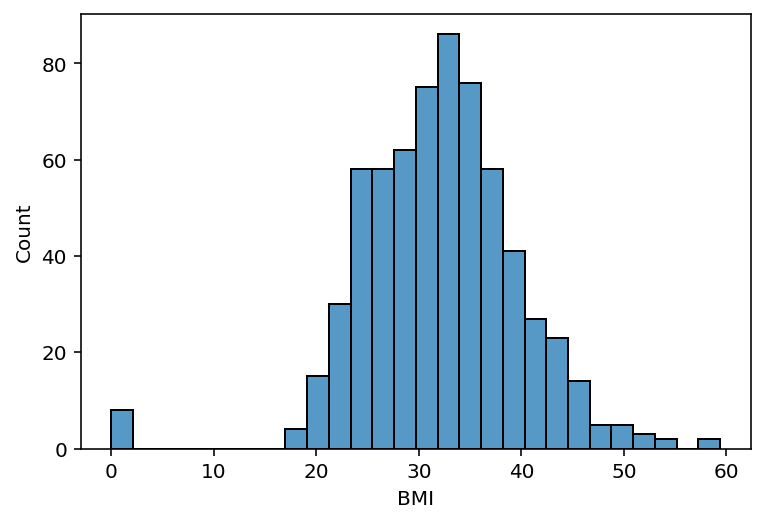

In [24]:
sns.histplot(X_train['BMI']);

* やはり欠測値の部分が0とされているようなので、先ほどと同様、中央値で埋める。


imputation fill value for BMI: 32.4


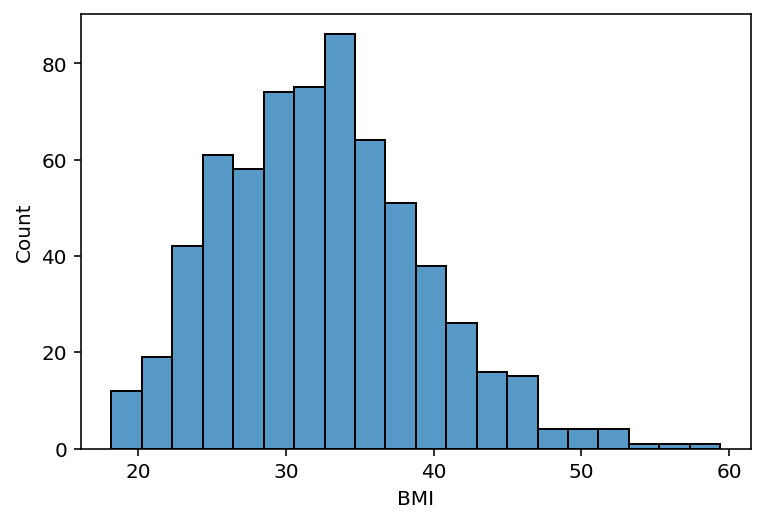

In [25]:
X_train_copy = X_train.copy()

feature = 'BMI'
imp = SimpleImputer(missing_values=0, strategy='median')
X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

sns.histplot(X_train_copy[feature]);

* 交差検証で評価する。

In [26]:
def preprocess(X_train, X_valid):
  imp = SimpleImputer(missing_values=0, strategy='median')

  X_train_copy = X_train.copy()
  X_valid_copy = X_valid.copy()

  for feature in ['BloodPressure', 'BMI']:
    X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
    X_valid_copy[feature] = imp.transform(X_valid[[feature]])
    print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

  return X_train_copy, X_valid_copy

In [27]:
cv(skf, X_train, y_train, preprocess=preprocess);

imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
score: 0.8333
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
score: 0.8030
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
score: 0.7846
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.1
score: 0.7538
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.45
score: 0.7692
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
score: 0.7846
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
score: 0.7538
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.3
score: 0.7846
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.349999999999994
score: 0.7077
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
score: 0.7385
mean score: 0.7713


* 下のようにテストセット以外全体で欠損値を埋めても、結果は変わらない。

In [28]:
X_train_copy = X_train.copy()

for feature in ['BloodPressure', 'BMI']:
  imp = SimpleImputer(missing_values=0, strategy='median')
  X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
  print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

cv(skf, X_train_copy, y_train);

imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
score: 0.8333
score: 0.8030
score: 0.7846
score: 0.7538
score: 0.7692
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7077
score: 0.7385
mean score: 0.7713


### F) Glucoseへの対応

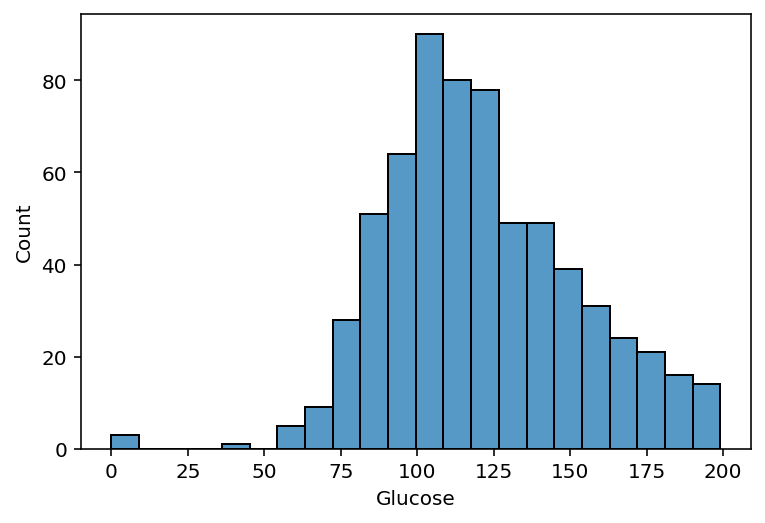

In [29]:
sns.histplot(X_train['Glucose']);

imputation fill value for Glucose: 117.0


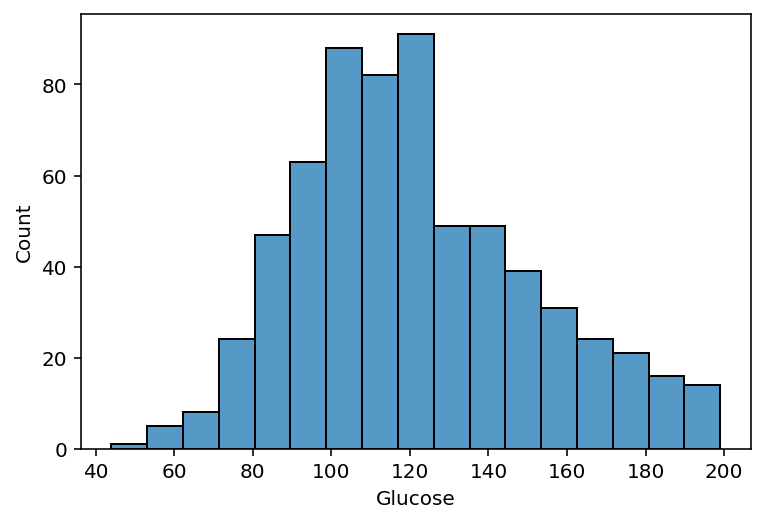

In [30]:
X_train_copy = X_train.copy()

feature = 'Glucose'
imp = SimpleImputer(missing_values=0, strategy='median')
X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

sns.histplot(X_train_copy[feature]);

In [31]:
def preprocess(X_train, X_valid):
  imp = SimpleImputer(missing_values=0, strategy='median')

  X_train_copy = X_train.copy()
  X_valid_copy = X_valid.copy()

  for feature in ['BloodPressure', 'BMI', 'Glucose']:
    X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
    X_valid_copy[feature] = imp.transform(X_valid[[feature]])
    print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

  return X_train_copy, X_valid_copy

In [32]:
cv(skf, X_train, y_train, preprocess=preprocess);

imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
score: 0.8333
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
score: 0.8182
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.5
score: 0.7846
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.1
imputation fill value for Glucose: 117.0
score: 0.7538
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.45
imputation fill value for Glucose: 117.5
score: 0.7846
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 116.0
score: 0.7846
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
score: 0.7538
imputation fill value for BloodPressure:

* 下のようにテストセット以外全体で欠損値を埋めても、結果は変わらない。

In [33]:
X_train_copy = X_train.copy()

for feature in ['BloodPressure', 'BMI', 'Glucose']:
  imp = SimpleImputer(missing_values=0, strategy='median')
  X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
  print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

cv(skf, X_train_copy, y_train);

imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
score: 0.8333
score: 0.8182
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7846
score: 0.7538
score: 0.8000
score: 0.7077
score: 0.7385
mean score: 0.7759


* ここまでの交差検証でのベスト・スコアは0.7759。

* 訓練データと検証データを区別して欠損値を埋めても、テストセット以外全体で欠損値を埋めても、結果はあまり変わらなさそう。
* 以下、単純に、テストセット以外全体で欠損値を埋めることで、ベストな前処理を探ることにする。

* X_trainの欠損値を埋めて、元のX_trainを上書きする。

In [34]:
X_train_copy = X_train.copy()

for feature in ['BloodPressure', 'BMI', 'Glucose']:
  imp = SimpleImputer(missing_values=0, strategy='median')
  X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
  print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

X_train = X_train_copy

cv(skf, X_train, y_train);

imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
score: 0.8333
score: 0.8182
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7846
score: 0.7538
score: 0.8000
score: 0.7077
score: 0.7385
mean score: 0.7759


### G) SkinThicknessとInsulinへの対応

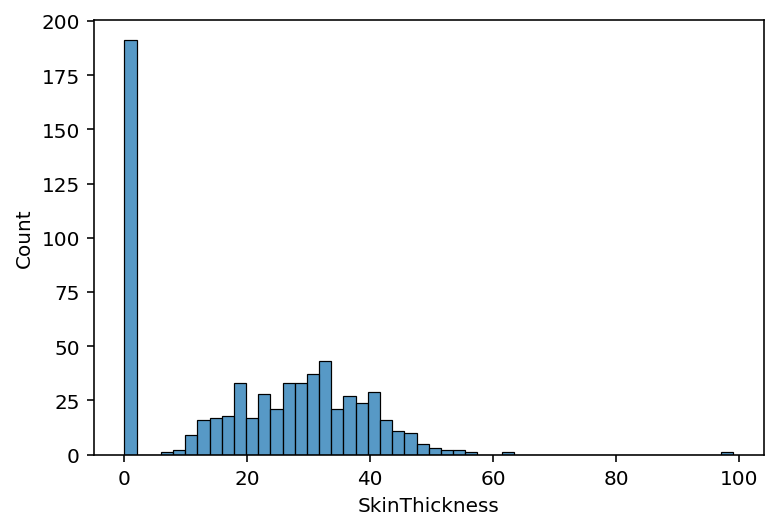

In [35]:
sns.histplot(X_train['SkinThickness'], bins=50);

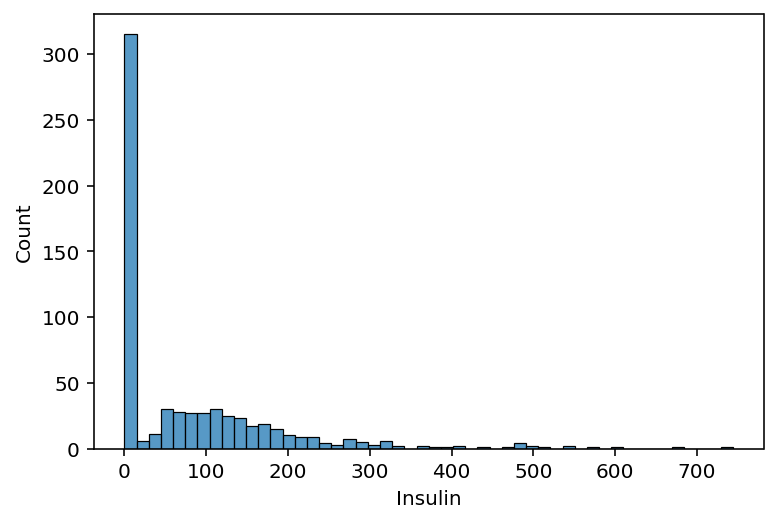

In [36]:
sns.histplot(X_train['Insulin'], bins=50);

In [37]:
(X_train['SkinThickness'] == 0).sum()

191

In [38]:
(X_train['Insulin'] == 0).sum()

314

* 欠測値が多すぎるので、同じ一つの値で埋めると、問題あり。

In [39]:
((X_train['SkinThickness'] == 0) & (X_train['Insulin'] == 0)).sum()

191

In [40]:
for i in X_train.index[X_train['SkinThickness'] == 0]:
  if not i in X_train.index[X_train['Insulin'] == 0]:
    print('No')

* SkinThicknessが0の個体は、必ずInsulinも0になっているらしい。

 * ただし、これは訓練データだけでこうなっているだけかもしれないので、この事実に依存して何かをすることはしない。

* 線形回帰でSkinThicknessとInsulinの欠測部分を埋める。
 * 欠測部分を同じ値で埋めたくないため。

In [41]:
# 欠測値を埋めるための回帰で、特徴量として使う列
columns = X_train.columns.drop('SkinThickness').drop('Insulin')

In [42]:
def preprocess(X_train, X_valid):

  X_train_copy = X_train.copy()
  X_valid_copy = X_valid.copy()

  for feature in ['SkinThickness', 'Insulin']:
    reg = LinearRegression()
    indices = (X_train[feature] != 0)
    reg.fit(X_train.loc[indices, columns], X_train.loc[indices, feature])
    X_train_copy.loc[~ indices, feature] = reg.predict(X_train.loc[~ indices, columns])

    indices = (X_valid[feature] != 0)
    X_valid_copy.loc[~ indices, feature] = reg.predict(X_valid.loc[~ indices, columns])

  return X_train_copy, X_valid_copy

In [43]:
cv(skf, X_train, y_train, preprocess=preprocess);

score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7385
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7714


* 悪くなったので不採用。

* 次は、k-NNを使って欠測値を埋める。

In [44]:
# columnsとkは、関数の外から値を指定する。

def preprocess(X_train, X_valid):
  print(f'imputation k-NN k={k}')

  X_train_copy = X_train.copy()
  X_valid_copy = X_valid.copy()

  for feature in ['SkinThickness', 'Insulin']:
    reg = KNeighborsRegressor(n_neighbors=k)
    indices = (X_train[feature] != 0)
    reg.fit(X_train.loc[indices, columns], X_train.loc[indices, feature])
    X_train_copy.loc[~ indices, feature] = reg.predict(X_train.loc[~ indices, columns])

    indices = (X_valid[feature] != 0)
    X_valid_copy.loc[~ indices, feature] = reg.predict(X_valid.loc[~ indices, columns])

  return X_train_copy, X_valid_copy

In [45]:
best_k, best_score = 1, 0.0

for k in range(1, 21):
  score = cv(skf, X_train, y_train, preprocess=preprocess)
  print('-'*64)
  if best_score < score:
    best_k, best_score = k, score

print(f'best score {best_score:.4f} for k = {best_k}')

imputation k-NN k=1
score: 0.8333
imputation k-NN k=1
score: 0.8030
imputation k-NN k=1
score: 0.7692
imputation k-NN k=1
score: 0.7385
imputation k-NN k=1
score: 0.8000
imputation k-NN k=1
score: 0.7692
imputation k-NN k=1
score: 0.7692
imputation k-NN k=1
score: 0.7846
imputation k-NN k=1
score: 0.7077
imputation k-NN k=1
score: 0.7538
mean score: 0.7729
----------------------------------------------------------------
imputation k-NN k=2
score: 0.8333
imputation k-NN k=2
score: 0.8182
imputation k-NN k=2
score: 0.7692
imputation k-NN k=2
score: 0.7385
imputation k-NN k=2
score: 0.8154
imputation k-NN k=2
score: 0.7846
imputation k-NN k=2
score: 0.7385
imputation k-NN k=2
score: 0.7846
imputation k-NN k=2
score: 0.7231
imputation k-NN k=2
score: 0.7538
mean score: 0.7759
----------------------------------------------------------------
imputation k-NN k=3
score: 0.8485
imputation k-NN k=3
score: 0.8182
imputation k-NN k=3
score: 0.7538
imputation k-NN k=3
score: 0.7538
imputation k-NN 

* 選ばれたkの値を使って、訓練データ全体で欠測値を埋める。

In [46]:
k = best_k

X_train_copy = X_train.copy()

for feature in ['SkinThickness', 'Insulin']:
  reg = KNeighborsRegressor(n_neighbors=k)
  indices = (X_train[feature] != 0)
  reg.fit(X_train.loc[indices, columns], X_train.loc[indices, feature])
  X_train_copy.loc[~ indices, feature] = reg.predict(X_train.loc[~ indices, columns])

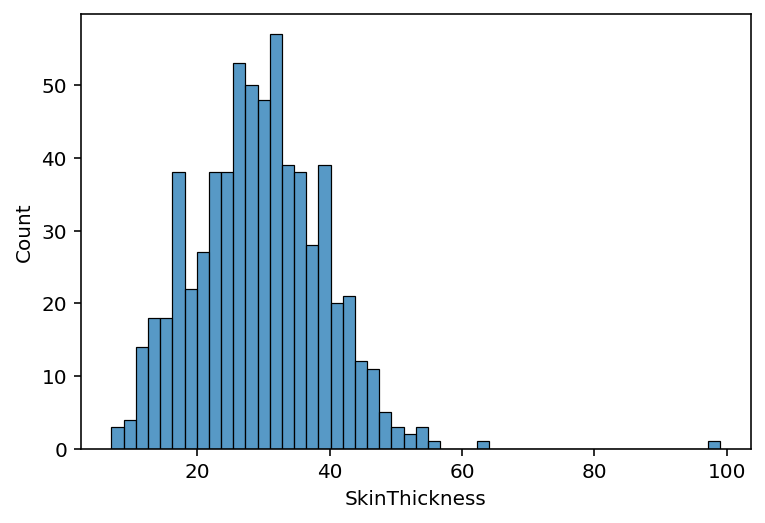

In [47]:
sns.histplot(X_train_copy['SkinThickness'], bins=50);

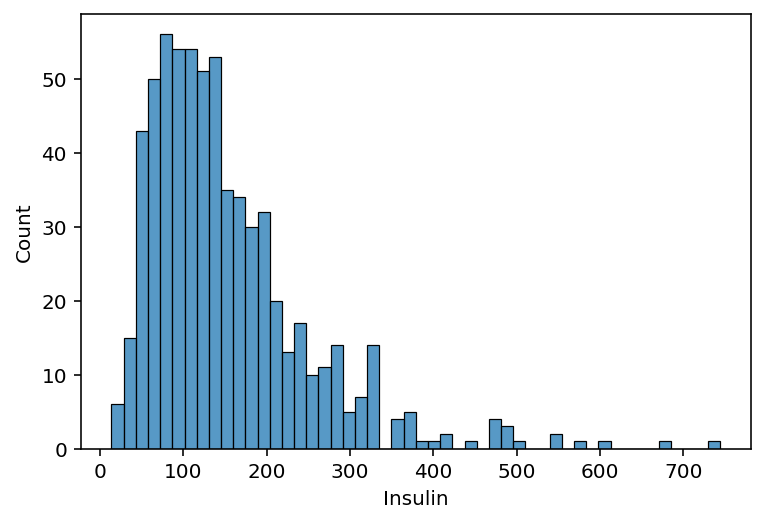

In [48]:
sns.histplot(X_train_copy['Insulin'], bins=50);

In [49]:
cv(skf, X_train_copy, y_train);

score: 0.8485
score: 0.8030
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7775


* 分類性能が良くなったので、埋めた後のデータセットを採用する。

In [50]:
X_train = X_train_copy

* Pregnanciesを除いて、値0は無くなっている。

In [51]:
(X_train == 0).sum()

Pregnancies                 91
Glucose                      0
BloodPressure                0
SkinThickness                0
Insulin                      0
BMI                          0
DiabetesPedigreeFunction     0
Age                          0
dtype: int64

### H) スケーラーを使ってみる。

In [52]:
def preprocess(X_train, X_valid):
  scaler = MinMaxScaler()
  scaler.fit(X_train)
  return scaler.transform(X_train), scaler.transform(X_valid)

In [53]:
cv(skf, X_train, y_train, preprocess=preprocess);

score: 0.7879
score: 0.8030
score: 0.7385
score: 0.7231
score: 0.7846
score: 0.7692
score: 0.7231
score: 0.7846
score: 0.7385
score: 0.7538
mean score: 0.7606


In [54]:
def preprocess(X_train, X_valid):
  scaler = StandardScaler()
  scaler.fit(X_train)
  return scaler.transform(X_train), scaler.transform(X_valid)

In [55]:
cv(skf, X_train, y_train, preprocess=preprocess);

score: 0.8485
score: 0.8182
score: 0.7538
score: 0.7385
score: 0.7846
score: 0.7692
score: 0.7538
score: 0.7846
score: 0.7231
score: 0.7538
mean score: 0.7728


いずれも不採用。

### I) 正則化パラメータをチューニングする。

In [56]:
best_C, best_score = 0, 0

for C in np.power(10.0, np.arange(13) - 5):
  score = cv(skf, X_train, y_train, C=C)
  if best_score < score:
    best_C, best_score = C, score
  print('-' * 64)

print(f'best score {best_score:.4f} for C={C}')

C = 1e-05
score: 0.6818
score: 0.8182
score: 0.7231
score: 0.6462
score: 0.7692
score: 0.7692
score: 0.7385
score: 0.7077
score: 0.7538
score: 0.7077
mean score: 0.7315
----------------------------------------------------------------
C = 0.0001
score: 0.8333
score: 0.8333
score: 0.7538
score: 0.6769
score: 0.7692
score: 0.7538
score: 0.7077
score: 0.7692
score: 0.7231
score: 0.7538
mean score: 0.7574
----------------------------------------------------------------
C = 0.001
score: 0.8485
score: 0.8030
score: 0.7385
score: 0.7231
score: 0.7846
score: 0.7692
score: 0.7692
score: 0.7846
score: 0.7385
score: 0.7846
mean score: 0.7744
----------------------------------------------------------------
C = 0.01
score: 0.8485
score: 0.8030
score: 0.7385
score: 0.7385
score: 0.8154
score: 0.7538
score: 0.7692
score: 0.7846
score: 0.7385
score: 0.7538
mean score: 0.7744
----------------------------------------------------------------
C = 0.1
score: 0.8485
score: 0.8182
score: 0.7385
score: 0.7538


* Cの値が大きいほど良いということは、正則化なしが良いということ。

In [57]:
cv(skf, X_train, y_train, penalty='none');

penalty = none
score: 0.8485
score: 0.8182
score: 0.7846
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.7846
score: 0.7231
score: 0.7538
mean score: 0.7790


* 以上をまとめると・・・
 * 'BloodPressure', 'BMI', 'Glucose'の欠損値は中央値で埋める。
 * 'SkinThickness', 'Insulin'の欠損値はk-NNで埋める。
 * ロジスティック回帰は正則化なしで使う。

## 5) テストデータで最終評価

* 訓練データの中央値を使って、テストデータの欠測値を埋める。

In [58]:
# 訓練データについては、最初に取っておいたオリジナル X_train_original を使うこと。

X_train_copy = X_train_original.copy()
X_test_copy = X_test.copy()

for feature in ['BloodPressure', 'BMI', 'Glucose']:
  imp = SimpleImputer(missing_values=0, strategy='median')
  X_train_copy[feature] = imp.fit_transform(X_train_original[[feature]])
  X_test_copy[feature] = imp.transform(X_test[[feature]])
  print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0


* k-NNでは、上で'BloodPressure', 'BMI', 'Glucose'の欠測値を埋めたデータを使う。

In [59]:
X_train = X_train_copy
X_test = X_test_copy

* 訓練データで近傍を見つけることによって、テストデータの欠測値を埋める。

In [60]:
k = best_k

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

for feature in ['SkinThickness', 'Insulin']:
  reg = KNeighborsRegressor(n_neighbors=k)
  indices = (X_train[feature] != 0)
  reg.fit(X_train.loc[indices, columns], X_train.loc[indices, feature])
  X_train_copy.loc[~ indices, feature] = reg.predict(X_train.loc[~ indices, columns])
  indices = (X_test[feature] != 0)
  X_test_copy.loc[~ indices, feature] = reg.predict(X_test.loc[~ indices, columns])

In [61]:
X_train = X_train_copy
X_test = X_test

In [62]:
model = LogisticRegression(max_iter=1000, penalty='none', random_state=123)
model.fit(X_train, y_train)
print('test score: {:.4f}'.format(model.score(X_test, y_test)))

test score: 0.7759


In [63]:
y_test_pred_proba = model.predict_proba(X_test)
print('ROC AUC: {:.4f}'.format(roc_auc_score(y_test, y_test_pred_proba[:,1])))

ROC AUC: 0.8696


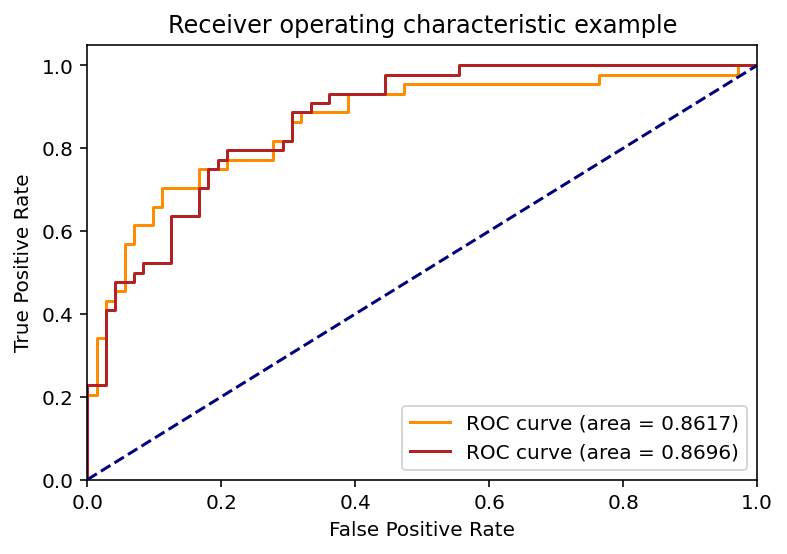

In [64]:
y_score = baseline.decision_function(X_test_original) # ベースラインには元のテストデータを使う
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

y_score_ours = model.decision_function(X_test)
fpr_ours, tpr_ours, _ = roc_curve(y_test, y_score_ours)
roc_auc_ours = auc(fpr_ours, tpr_ours)

plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot(fpr_ours, tpr_ours, color='firebrick', label=f'ROC curve (area = {roc_auc_ours:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right");

# 2022/06/11の課題
* 上の結果を改良できるかどうか、試行錯誤してみてください。